In [1]:
import pandas as pd
import altair as alt

# Need to enable this to allow work with larger datasets (https://altair-viz.github.io/user_guide/faq.html)
#alt.data_transformers.enable('json')
selection = alt.selection_single();

In [2]:
movies_df = pd.read_json('https://raw.githubusercontent.com/vega/vega-datasets/master/data/movies.json')

# Add a column of the release year
movies_df['Year'] = pd.to_datetime(movies_df['Release_Date']).dt.year
# A list columns that will appear in the final data frame
movies_df['Profit_Million'] = (movies_df['Worldwide_Gross'] - movies_df['Production_Budget'])/1000_000
column_list = ['Title', 'Major_Genre', 'Director', 'Year', 'Profit_Million', 'IMDB_Rating', 'MPAA_Rating']

# Filter out lines with errors or NaNs in 'Director', 'Year', 'Major_Genre' columns
movies_df = (movies_df.query('Year < 2019')
                     .dropna(subset = column_list)
                     .loc[:, column_list]
                     .reset_index()
                     .drop(columns = ['index']))


In [3]:
movies_df.shape

(1414, 7)

In [4]:
movies_df.describe()

,Year,Profit_Million,IMDB_Rating
count,1414.000000,1414.000000,1414.000000
mean,2001.524045,87.144301,6.443069
std,5.699895,166.377465,1.160132
min,1960.000000,-94.635231,1.700000
25%,1998.000000,-2.209231,5.700000
50%,2002.000000,29.174308,6.500000
75%,2006.000000,110.943246,7.300000
max,2010.000000,2530.891499,9.200000


In [5]:
movies_df.to_csv('../data/clean/movies_clean_df.csv')

In [6]:
def make_plot(genre = 'Action'):
    # Don't forget to include imports
    def mds_special():
        font = "Arial"
        axisColor = "#000000"
        gridColor = "#DEDDDD"
        return {
            "config": {
                "title": {
                    "fontSize": 24,
                    "font": font,
                    "anchor": "start", # equivalent of left-aligned.
                    "fontColor": "#000000"
                },
                'view': {
                    "height": 300, 
                    "width": 400
                },
                "axisX": {
                    "domain": True,
                    #"domainColor": axisColor,
                    "gridColor": gridColor,
                    "domainWidth": 1,
                    "grid": False,
                    "labelFont": font,
                    "labelFontSize": 12,
                    "labelAngle": 0, 
                    "tickColor": axisColor,
                    "tickSize": 5, # default, including it just to show you can change it
                    "titleFont": font,
                    "titleFontSize": 16,
                    "titlePadding": 10, # guessing, not specified in styleguide
                    "title": "X Axis Title (units)", 
                },
                "axisY": {
                    "domain": False,
                    "grid": True,
                    "gridColor": gridColor,
                    "gridWidth": 1,
                "labelFont": font,
                "labelFontSize": 14,
                "labelAngle": 0, 
                #"ticks": False, # even if you don't have a "domain" you need to turn these off.
                "titleFont": font,
                "titleFontSize": 16,
                "titlePadding": 10, # guessing, not specified in styleguide
                "title": "Y Axis Title (units)", 
                # titles are by default vertical left of axis so we need to hack this 
                #"titleAngle": 0, # horizontal
                #"titleY": -10, # move it up
                #"titleX": 18, # move it to the right so it aligns with the labels 
            },
        }
    }    
    
    # register the custom theme under a chosen name
    alt.themes.register('mds_special', mds_special)
    # enable the newly registered theme
    alt.themes.enable('mds_special')
    #alt.themes.enable('none') # to return to default
    
    def get_top_df(df, num, genre):
        """
        Finds the number of movies of the most productive directors in the selected genre and 
        movie information from the most productive directors in the selected genre.

        Parameters
        ----------
        df: pandas.DataFrame
            The data frame to work on
        num: int
            The number of directors to keep in each genre
        genre: string
            The selected genre

        Returns
        -------
        (pandas.DataFrame, pandas.DataFrame)
            The data frame only contains movie information from the most productive directors in the selected genre and 
            The data frame contains the number of movies of the most productive directors in the selected genre  
            
        """

        mdfg = df.groupby('Major_Genre')
        top_director = (mdfg.get_group(genre)
                        .groupby('Director')
                        .count()
                        .sort_values(by = 'Title', ascending = False)
                        .head(num)
                        .reset_index()
                        .iloc[:, :2]
                        .rename(columns = {'Title': 'Count'}))    
        top_director['Major_Genre'] = genre
        top_df = pd.merge(df, 
                          top_director, 
                          how = "inner",
                          on = ['Major_Genre', 'Director'])
        return (top_director, top_df)

   

    
    # get the clean movies data
    movies_df = pd.read_csv('../data/clean/movies_clean_df.csv', index_col = 0)
    
    # get information from the 30 most productive directors in the selected genre
    top_director, top_df = get_top_df(movies_df, 30, genre)

    brush = alt.selection(type='multi', fields=['Director'], init={'Director':top_director.iloc[0, 0]})
    
    chart_1 = alt.Chart(top_director).mark_bar().encode(
                alt.Y('Director:N', 
                      title='Director', 
                      sort=alt.EncodingSortField(field="Count:Q",
                                                 order="ascending")),
                alt.X('Count:Q', 
                      title='Number of movies'),
                opacity=alt.condition(brush, alt.value(0.75), alt.value(0.05)),
              ).properties(
                title='Top 30 productive directors in ' + genre,
                width=200, 
                height=650
              ).add_selection(brush)
    
    chart_2 = alt.Chart(top_df).mark_line(point=True).encode(
                alt.X("Year:O", 
                      axis=alt.Axis(title="Year")),
                alt.Y("IMDB_Rating:Q", 
                      axis=alt.Axis(title="IMDB Rating (1-10)"), 
                      scale=alt.Scale(zero=False)),
                alt.Color('Director:N'),
                opacity=alt.condition(brush, alt.value(0.75), alt.value(0.05)),
                tooltip = ['Title', 'Major_Genre', 'Director', 'IMDB_Rating']
              ).properties(
                title='IMDB Rating',
                width=400, height=250
              ).interactive().transform_filter(brush)
    
    chart_3 = alt.Chart(top_df).mark_line(point=True).encode(
                alt.X("Year:O",
                      axis=alt.Axis(title="Year")),
                alt.Y("Profit_Million:Q", 
                      axis=alt.Axis(title="Profit (million USD)"), 
                      scale=alt.Scale(zero=False)),
                alt.Color('Director:N'),
                opacity=alt.condition(brush, alt.value(0.75), alt.value(0.05)),
                tooltip = ['Title', 'Major_Genre', 'Director', 'IMDB_Rating']
            ).properties(title='Worldwide Profit',
                        width=400, height=250).interactive().transform_filter(brush)
    
    return chart_1 | (chart_2 & chart_3)

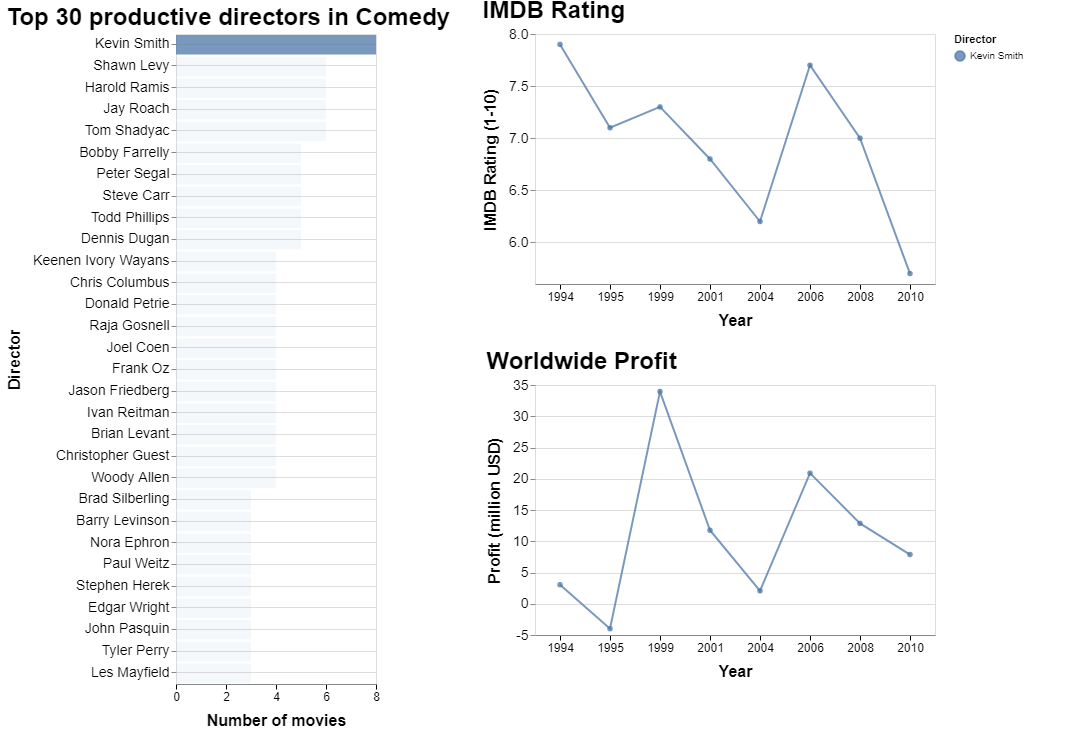

In [7]:
make_plot(genre = 'Comedy') 